<a href="https://www.kaggle.com/code/najeebz/s4e3-tensorflow-cnn-hyperparameter-tuning-optuna?scriptVersionId=167513173" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# [Steel Plate Defect Prediction](https://www.kaggle.com/competitions/playground-series-s4e3)
### Playground Series - Season 4, Episode 3

​
_______________________________________________________________________ 
# Author Details:
- Name: Najeeb Haider Zaidi
- Email: zaidi.nh@gmail.com
- Profiles: [Github](https://github.com/snajeebz)  [LinkedIn](https://www.linkedin.com/in/najeebz) [Kaggle](https://www.kaggle.com/najeebz)
- Prepared for the submission to the competition.
________________________________________________________________________
# Attributions:

​
1. [Walter Reade, Ashley Chow. (2024). Steel Plate Defect Prediction. Kaggle.](https://kaggle.com/competitions/playground-series-s4e3)

________________________________________________________________________
•
This Notebook is to be submitted to the competition so aims to start the process from the beginning to the creation of the submission csv file in proper format.
__________________________________________________________________________
# Code Execution and Versioning Repository: 
- [Execute the notebook in Kaggle](https://www.kaggle.com/code/najeebz/steel-plate-defect-tensorflow-neural-net-optuna)
- [Github Repository](https://github.com/snajeebz/playground)
•
____________________________________________________________________
# Citation:
​
Najeeb Zaidi. (2024). Steel Plate Defect Prediction. Competition Submission. Kaggle. https://www.kaggle.com/code/najeebz/steel-plate-defect-tensorflow-neural-net-optuna

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from warnings import filterwarnings;
filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-03-17 21:22:52.184060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 21:22:52.184158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 21:22:52.298697: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


# Reading the Dataset

In [2]:
df=pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')

# Initial EDA

In [3]:
df.head(10)

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1
5,5,1009,1033,899231,899307,409,22,26,47513,86,...,0.5909,-0.1890,0.8749,0,0,0,0,0,0,1
6,6,596,607,739072,7390760,204,21,21,22478,89,...,0.3158,-0.1497,0.5212,0,0,0,0,0,1,0
7,7,1673,1687,294065,294091,571,38,57,53142,77,...,0.0357,-0.2661,0.9408,1,0,0,0,0,0,0
8,8,507,521,203252,203261,101,25,12,12530,124,...,-0.6667,0.0305,0.3601,0,0,0,0,0,0,0
9,9,893,907,1341292,1341296,54,6,15,7052,87,...,0.4667,-0.1228,0.1400,0,0,0,0,0,1,0


In [4]:
df.isnull().sum()


id                       0
X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

In [5]:
df.columns

Index(['id', 'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum',
       'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

In [6]:
test.columns

Index(['id', 'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum',
       'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas'],
      dtype='object')

In [7]:
df.nunique()

id                       19219
X_Minimum                 1191
X_Maximum                 1259
Y_Minimum                 3345
Y_Maximum                 3341
Pixels_Areas              1154
X_Perimeter                460
Y_Perimeter                331
Sum_of_Luminosity         2595
Minimum_of_Luminosity      162
Maximum_of_Luminosity       98
Length_of_Conveyer          99
TypeOfSteel_A300             2
TypeOfSteel_A400             2
Steel_Plate_Thickness       27
Edges_Index               1849
Empty_Index               1748
Square_Index              1118
Outside_X_Index            525
Edges_X_Index             1102
Edges_Y_Index              900
Outside_Global_Index         4
LogOfAreas                1072
Log_X_Index                206
Log_Y_Index                241
Orientation_Index         1598
Luminosity_Index          2046
SigmoidOfAreas             467
Pastry                       2
Z_Scratch                    2
K_Scatch                     2
Stains                       2
Dirtines

In [8]:
train_df=df.copy()

In [9]:
train_df['summary']=train_df['Pastry']+train_df['Z_Scratch']+train_df['K_Scatch']+train_df['Stains']+train_df['Dirtiness']+train_df['Bumps']+train_df['Other_Faults']

In [10]:
train_df['summary'].value_counts()

summary
1    18380
0      818
2       21
Name: count, dtype: int64

There are 21 rows in which we have more than one column True i-e two defects.
and 818 where none of the columns are true, so no defects.

In [11]:
train_df[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']].value_counts()

Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
0       0          0         0       0          0      1               6540
                                                1      0               4761
                   1         0       0          0      0               3411
1       0          0         0       0          0      0               1465
0       1          0         0       0          0      0               1150
        0          0         0       0          0      0                818
                             1       0          0      0                568
                             0       1          0      0                485
                   1         0       0          0      1                 18
                                                1      0                  2
1       0          1         0       0          0      0                  1
Name: count, dtype: int64

In [12]:
cat_cols=train_df[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults', 'TypeOfSteel_A300','TypeOfSteel_A300','Outside_Global_Index', 'summary' ]]
num_cols=train_df.drop(columns=['id','Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults', 'TypeOfSteel_A300','TypeOfSteel_A300','Outside_Global_Index', 'summary' ])

# Visualizations

# Categorical Columns Count Plots

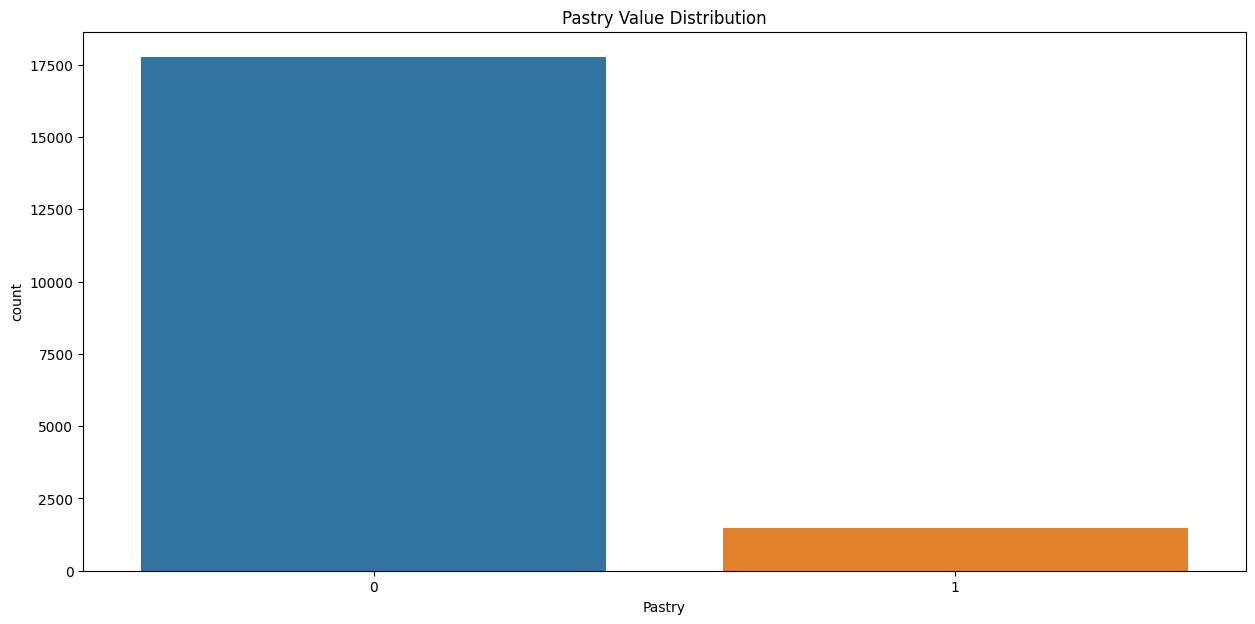

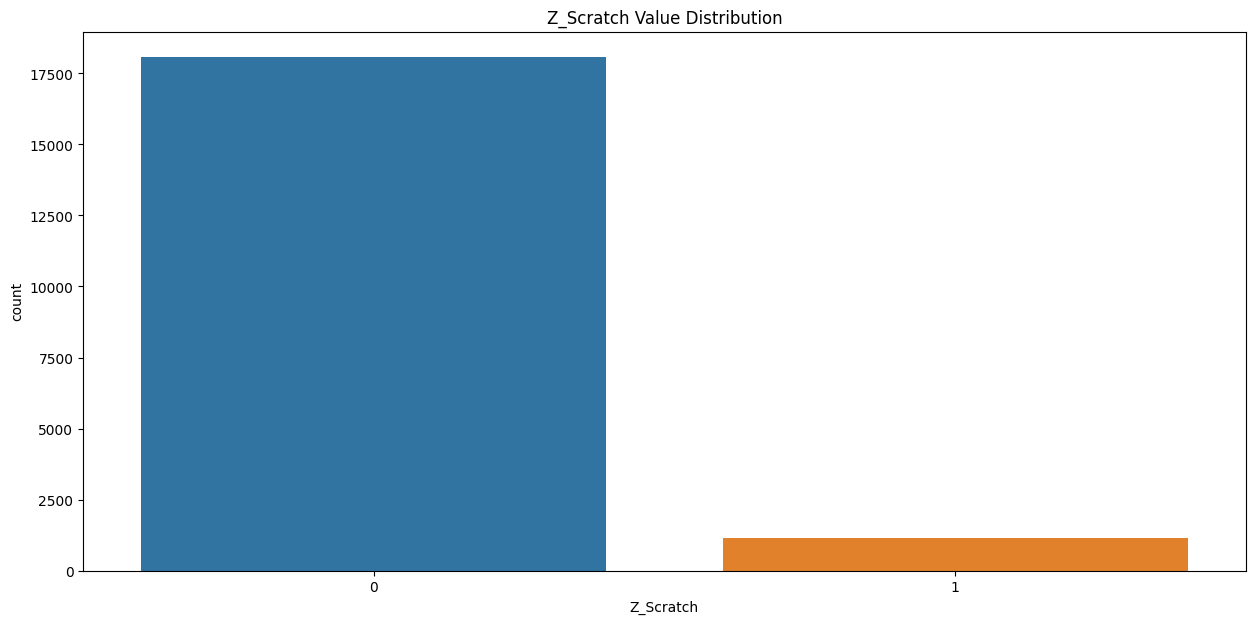

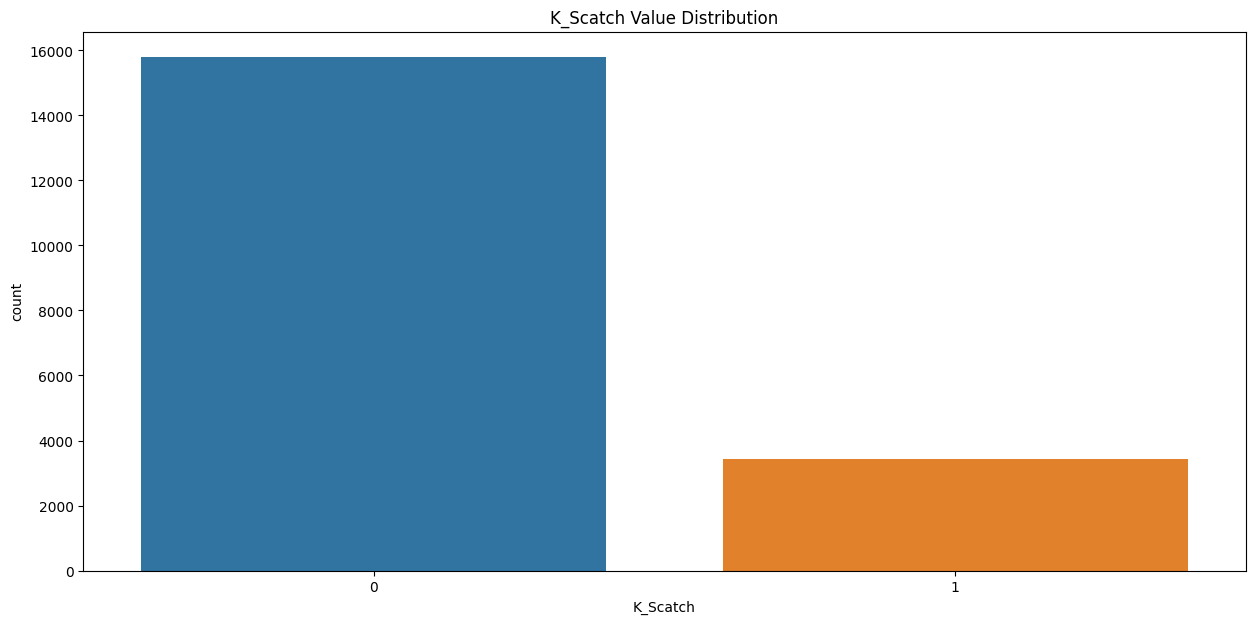

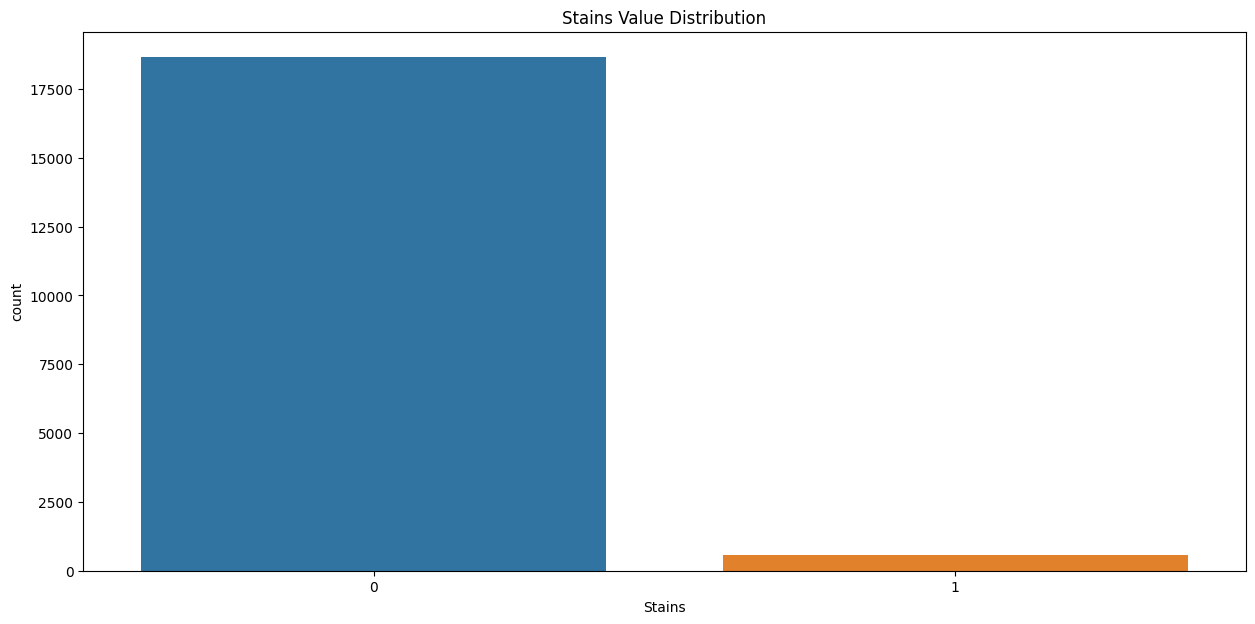

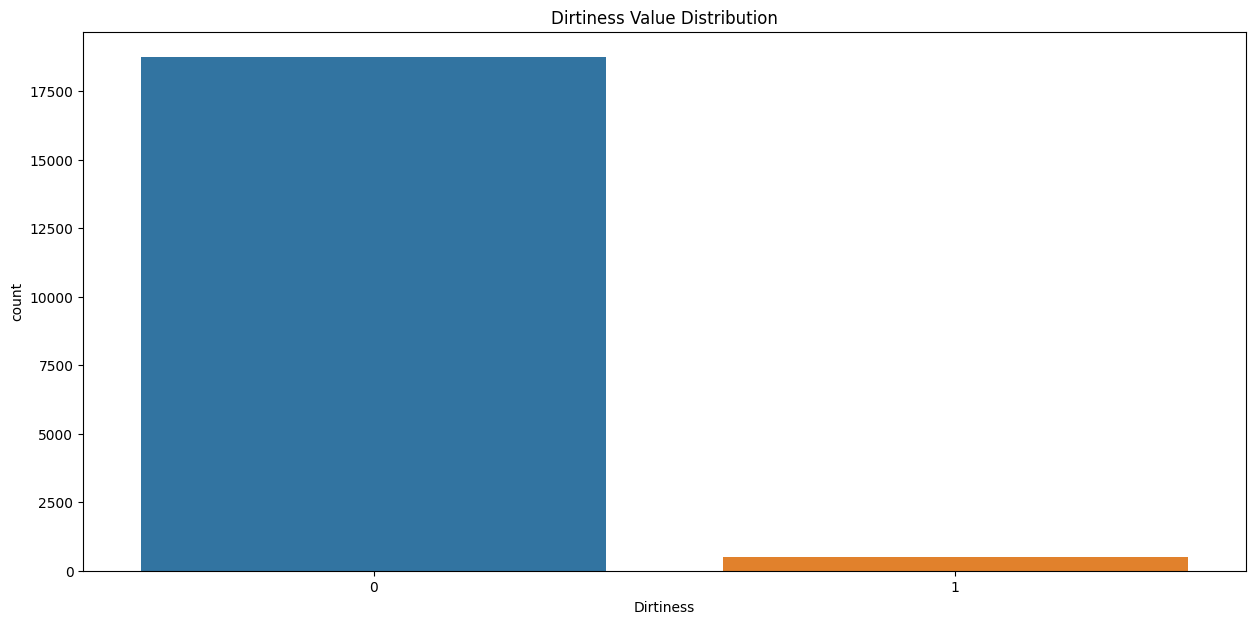

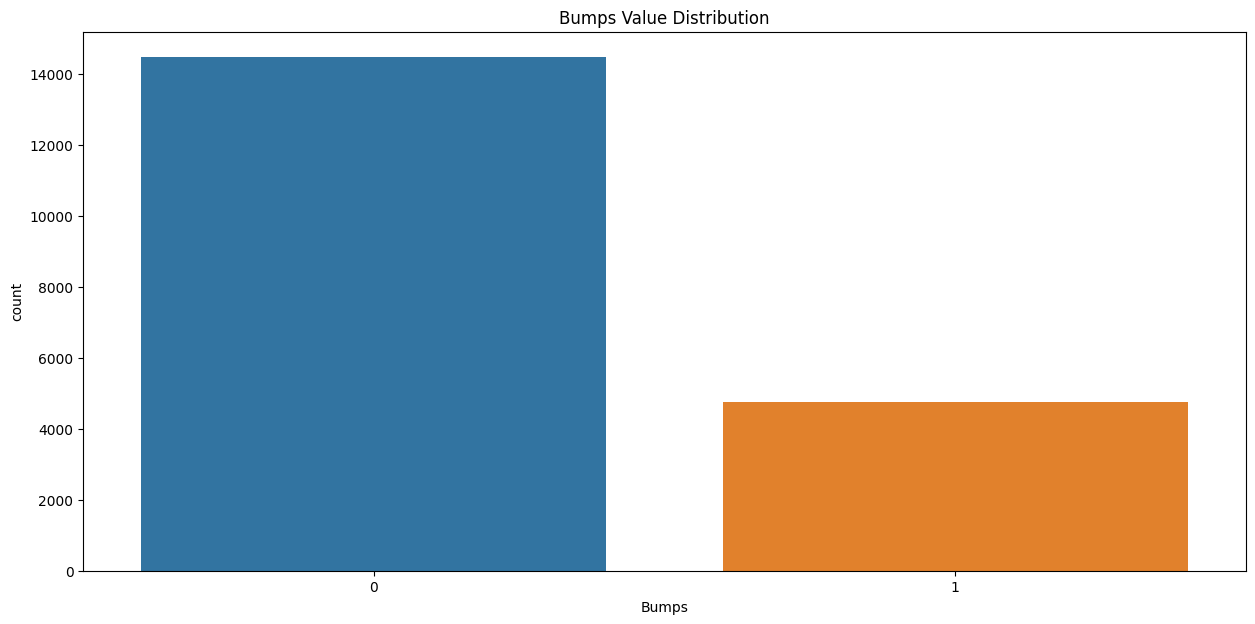

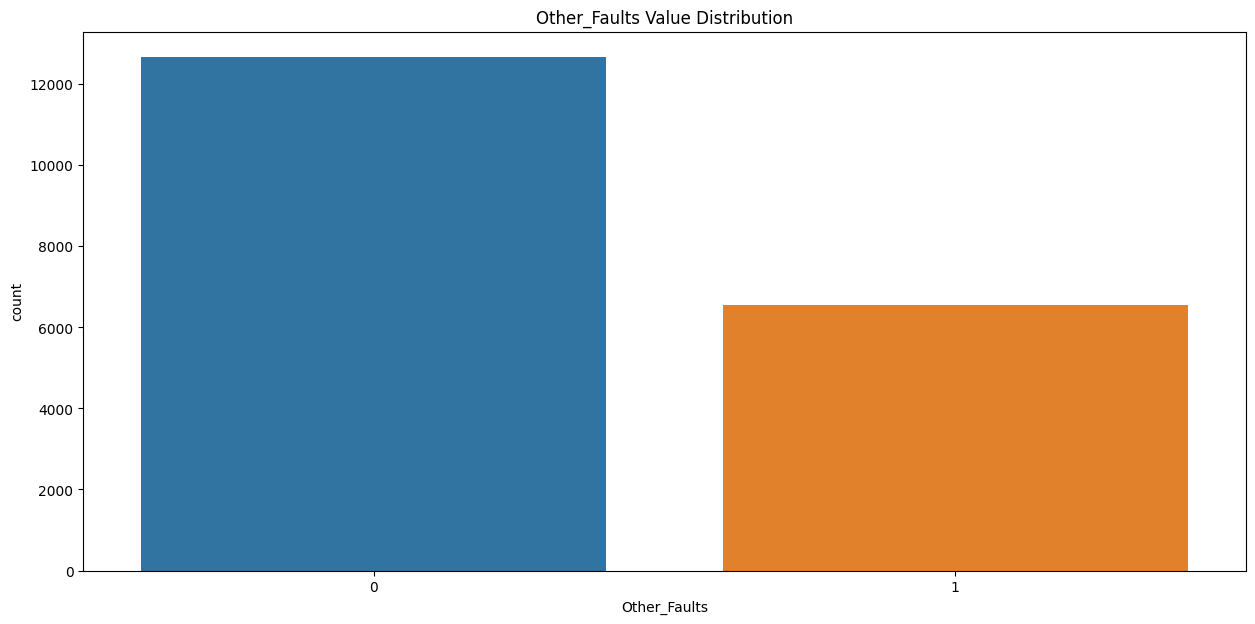

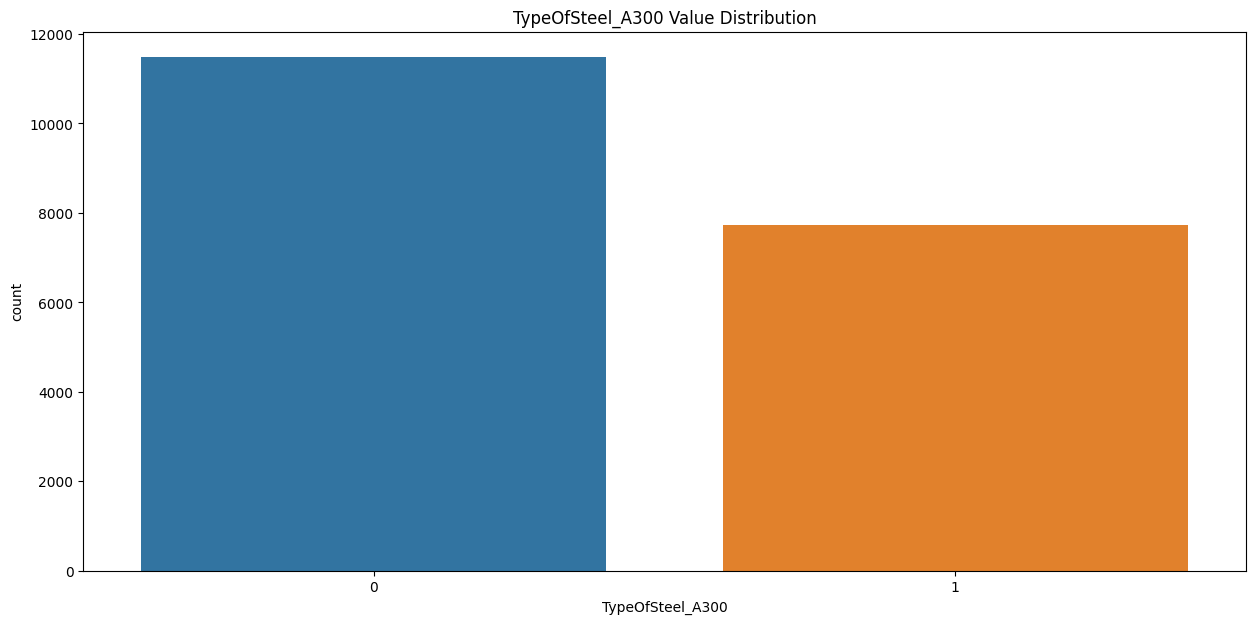

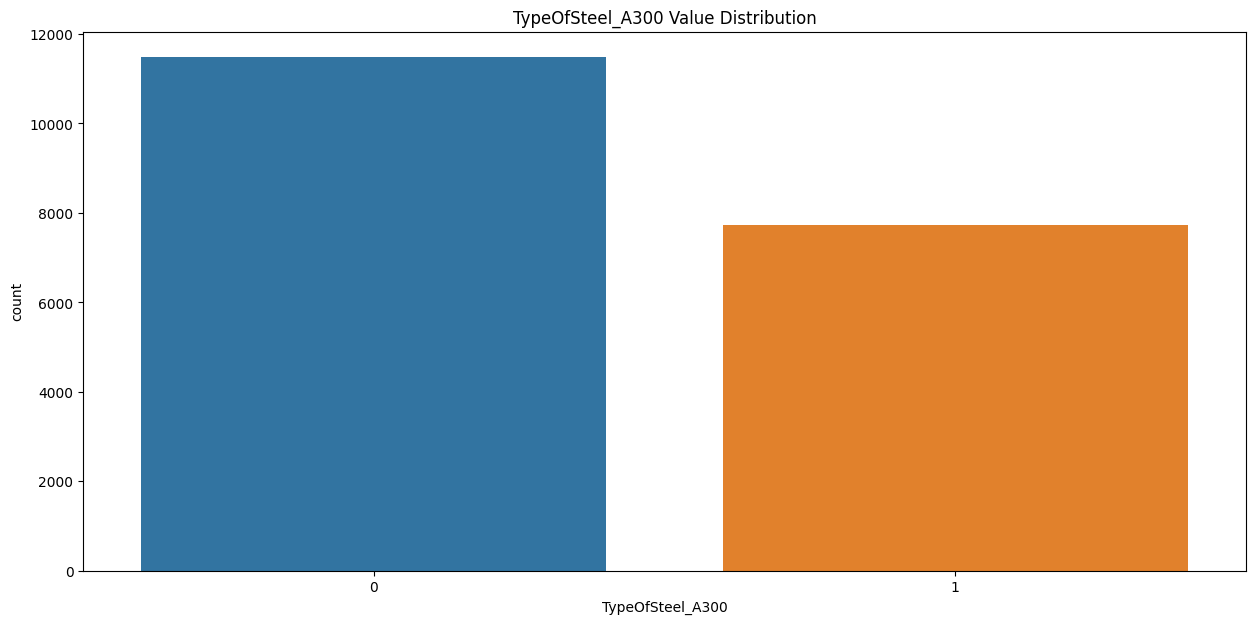

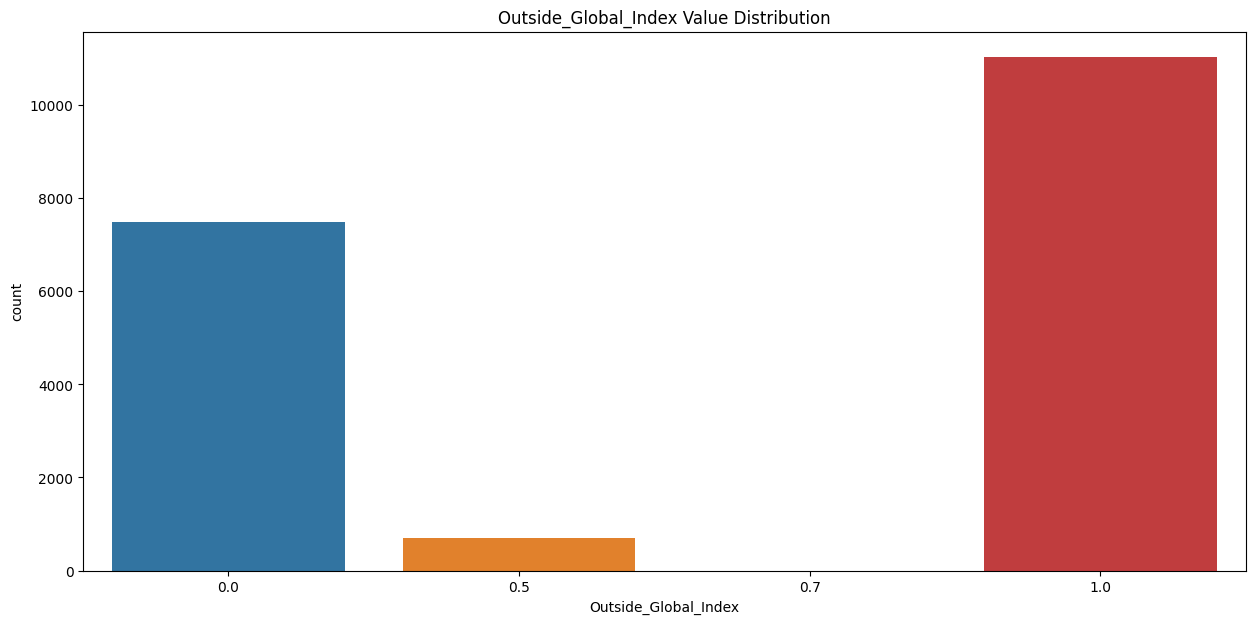

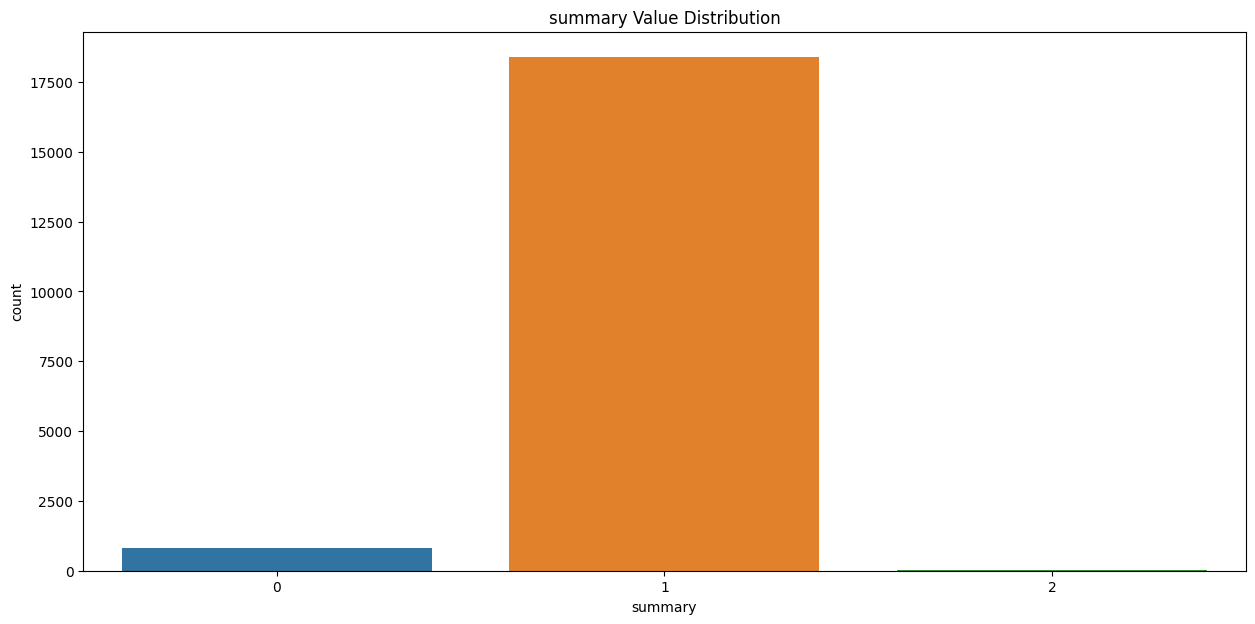

In [13]:
for col in cat_cols:
    plt.figure(figsize=[15,7])
    sns.countplot(df,x=train_df[col]).set(title= col+' Value Distribution')
    plt.show()

# Numerical Columns Histograms

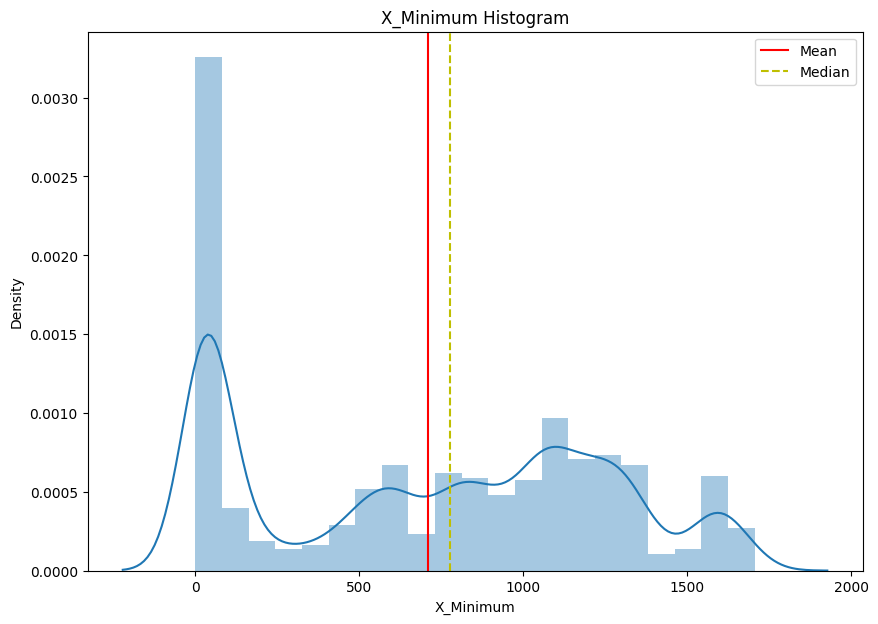

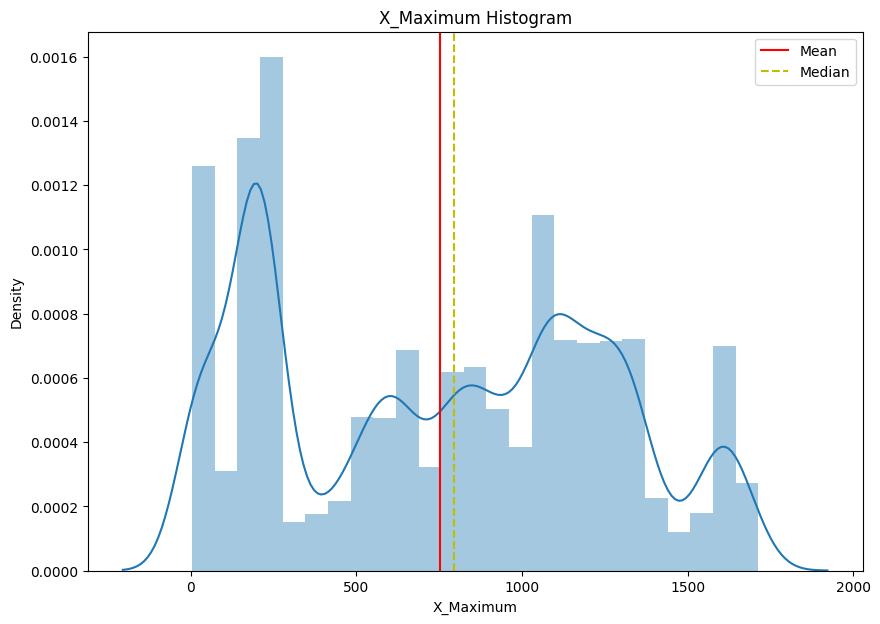

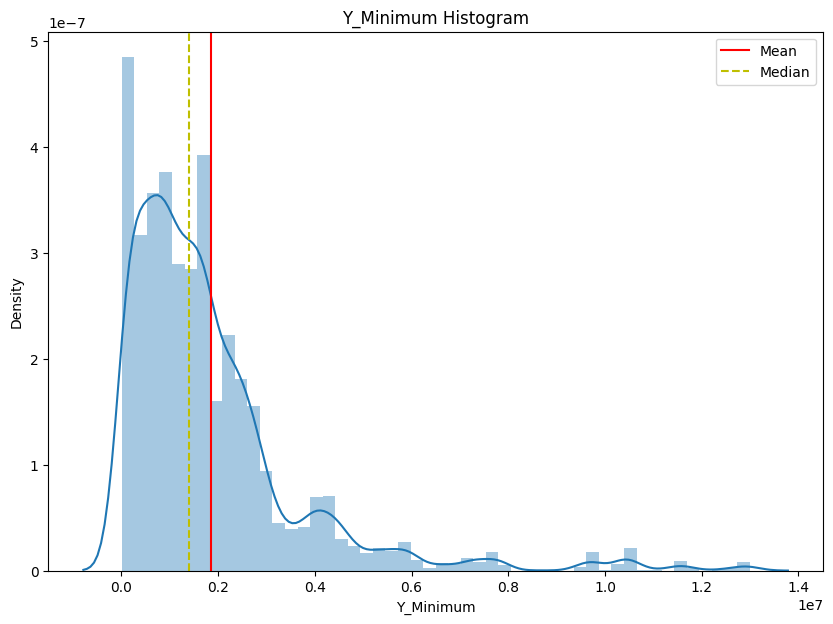

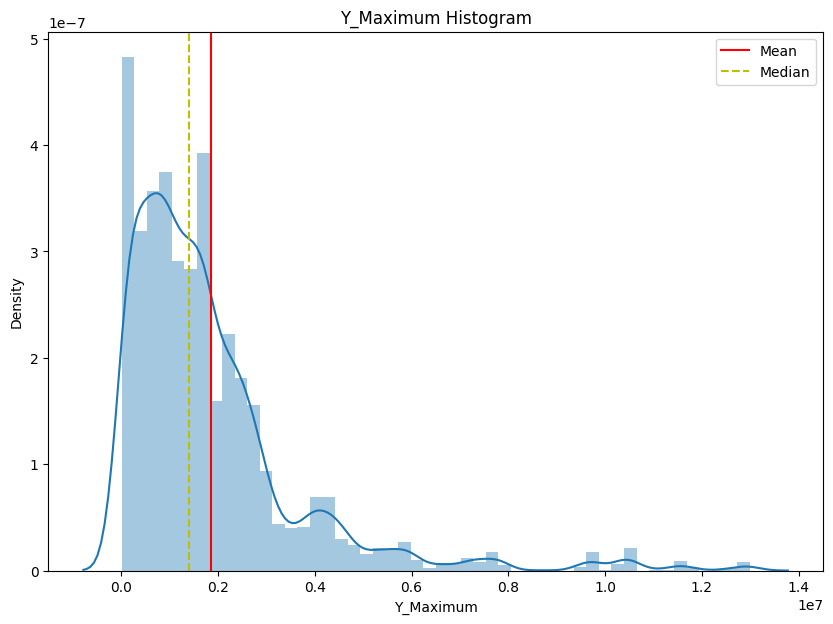

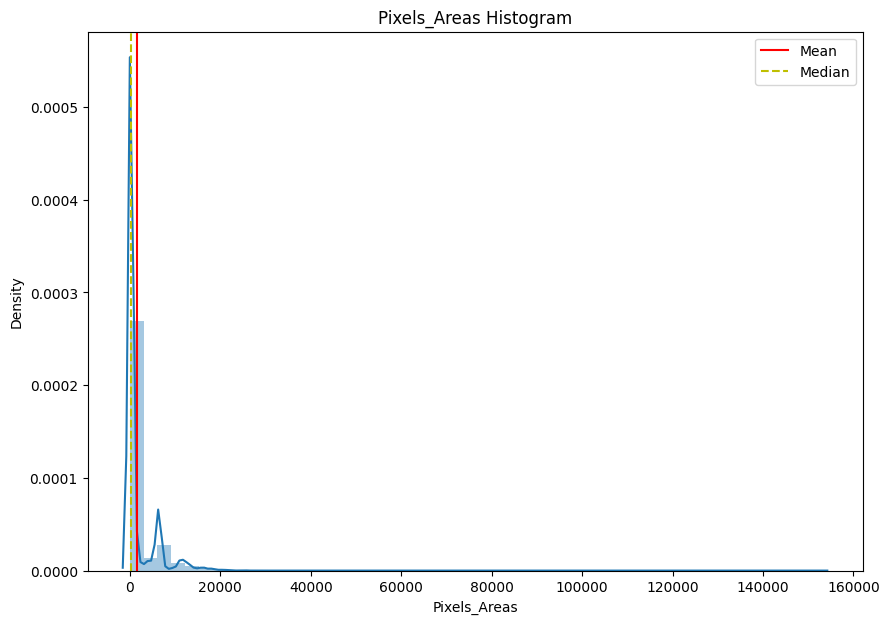

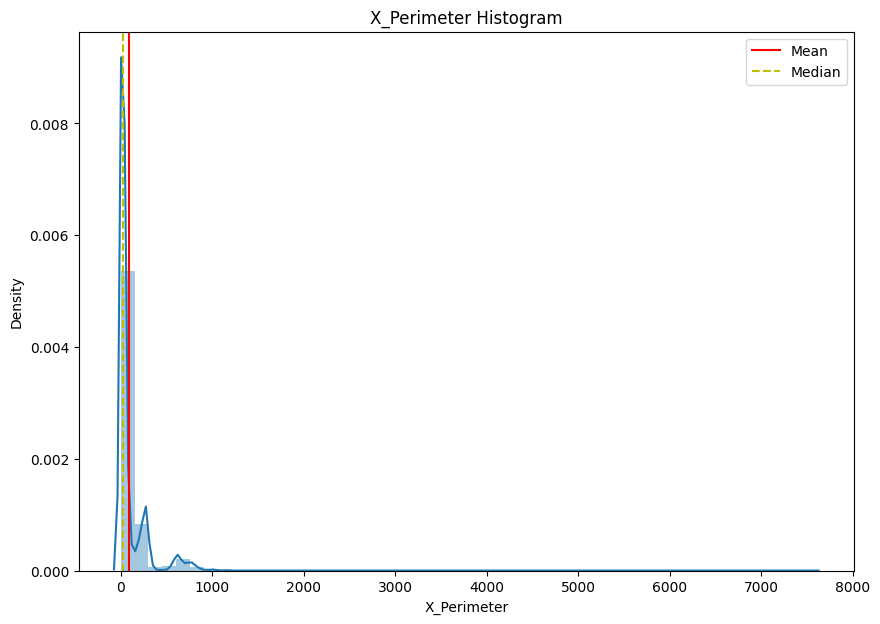

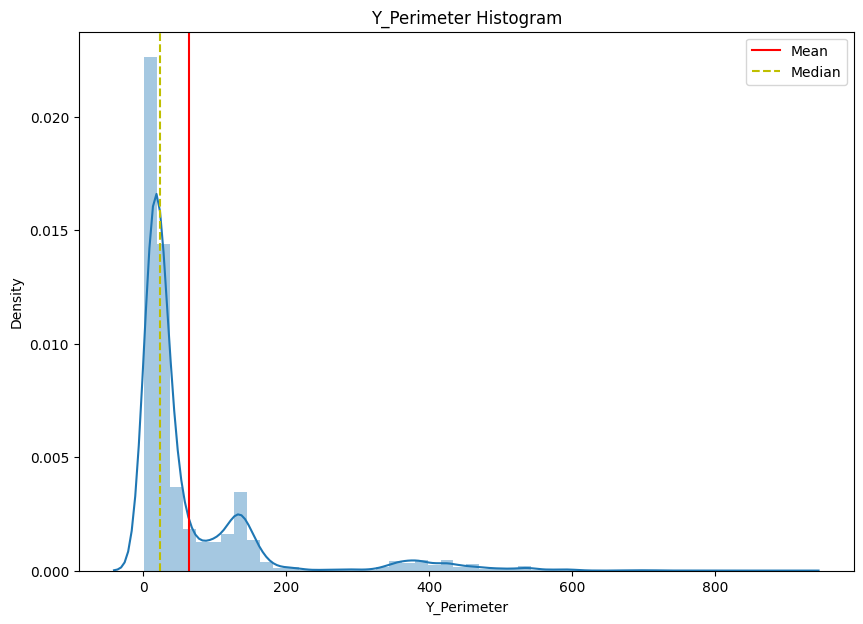

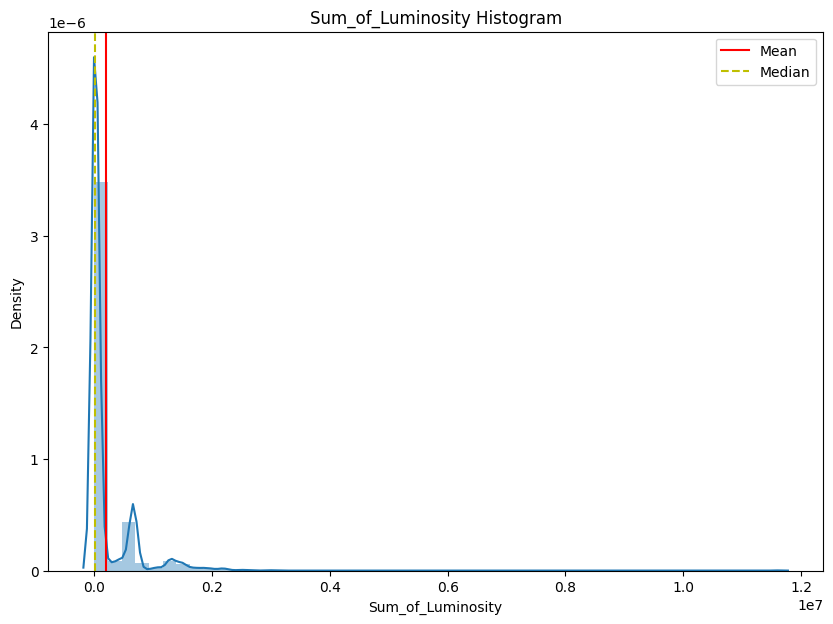

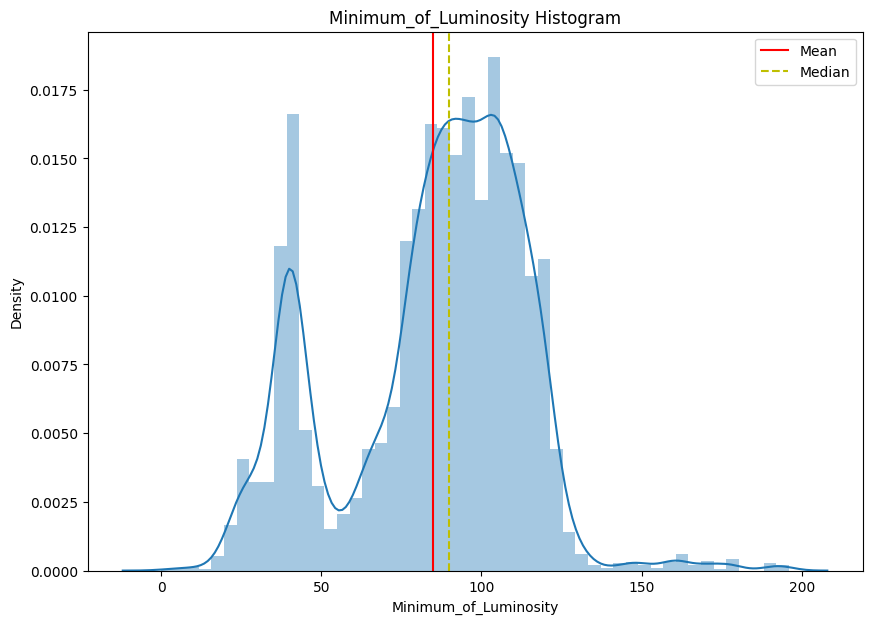

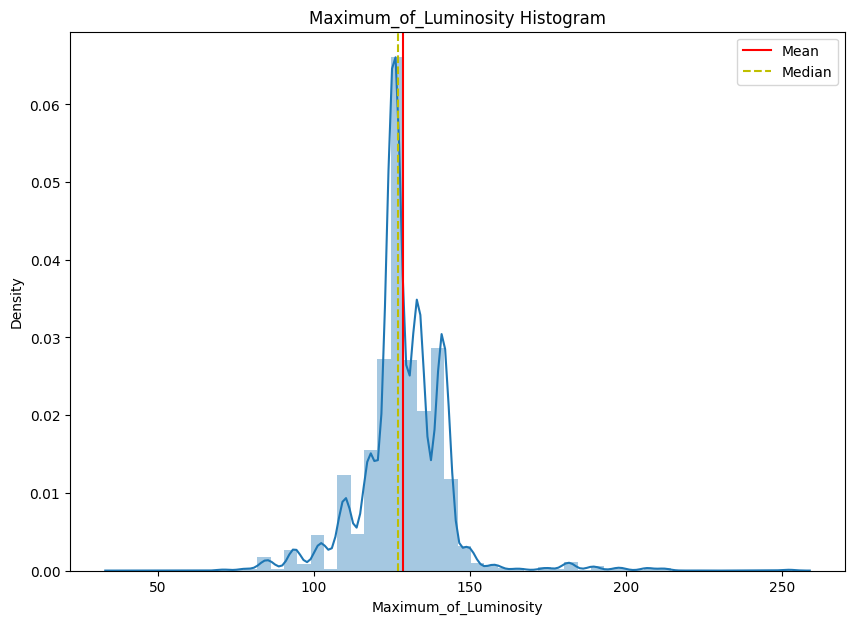

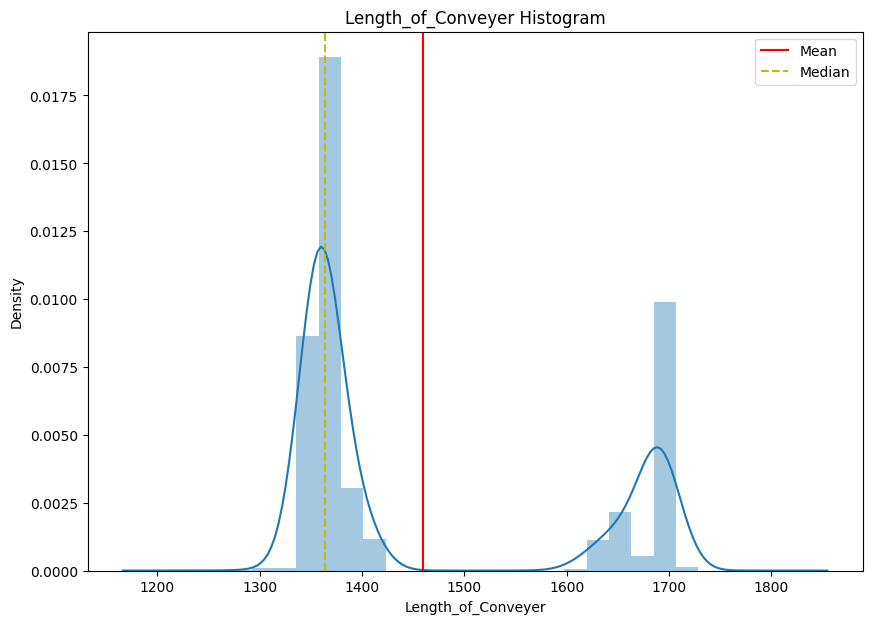

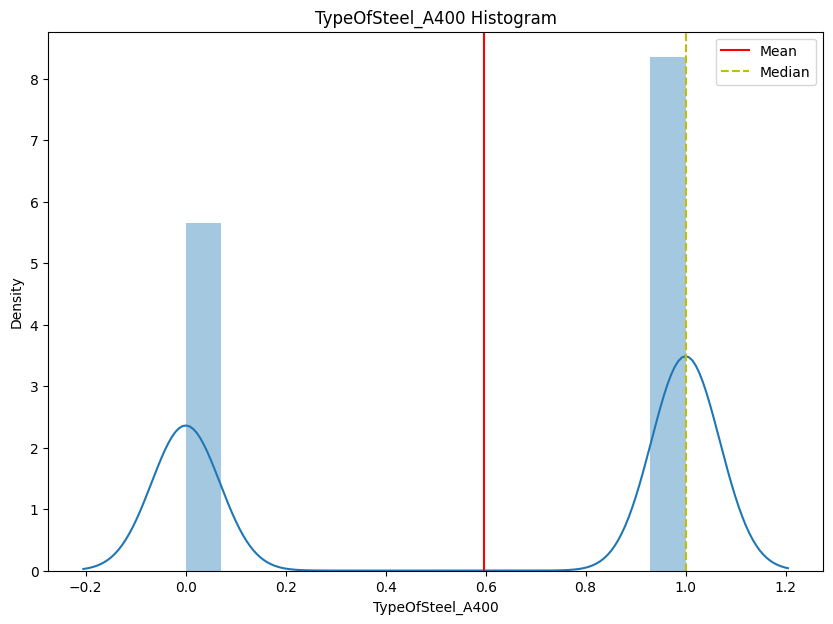

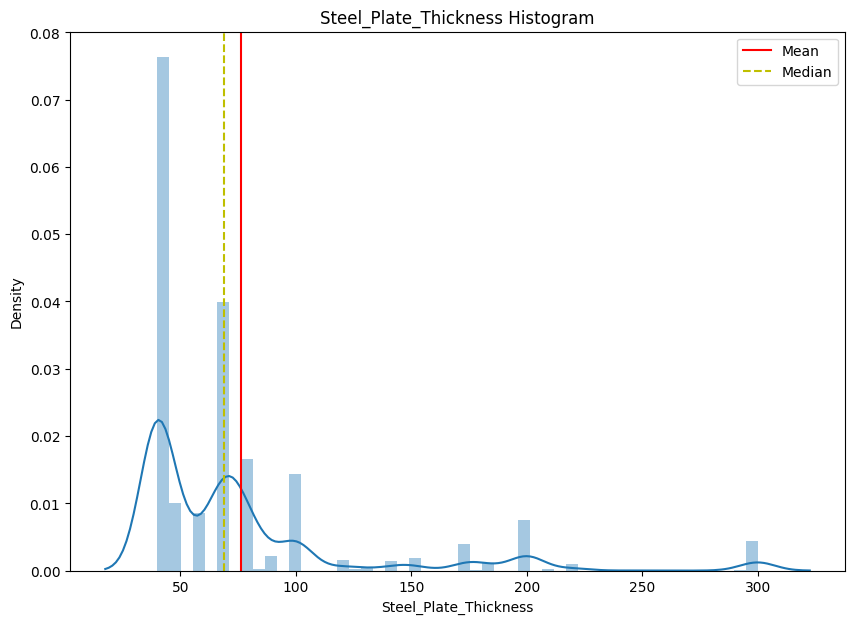

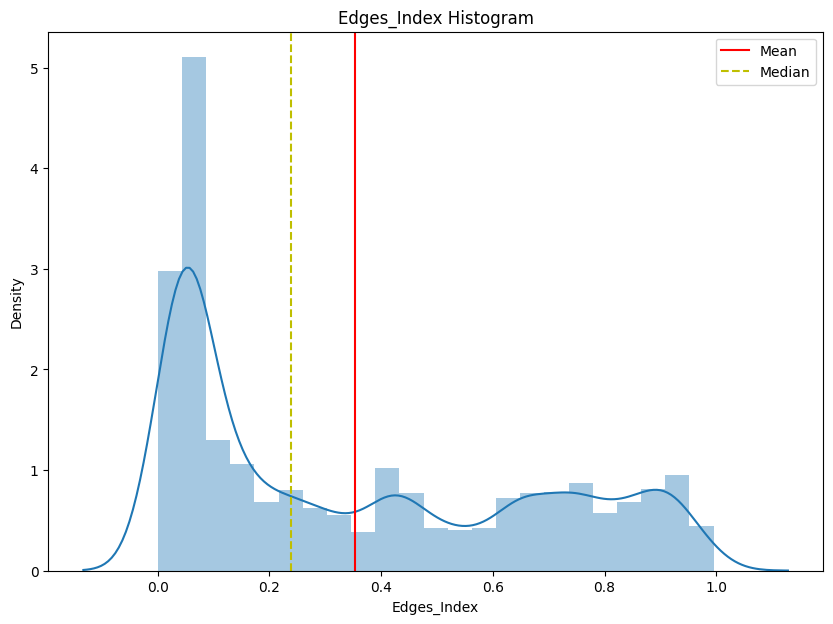

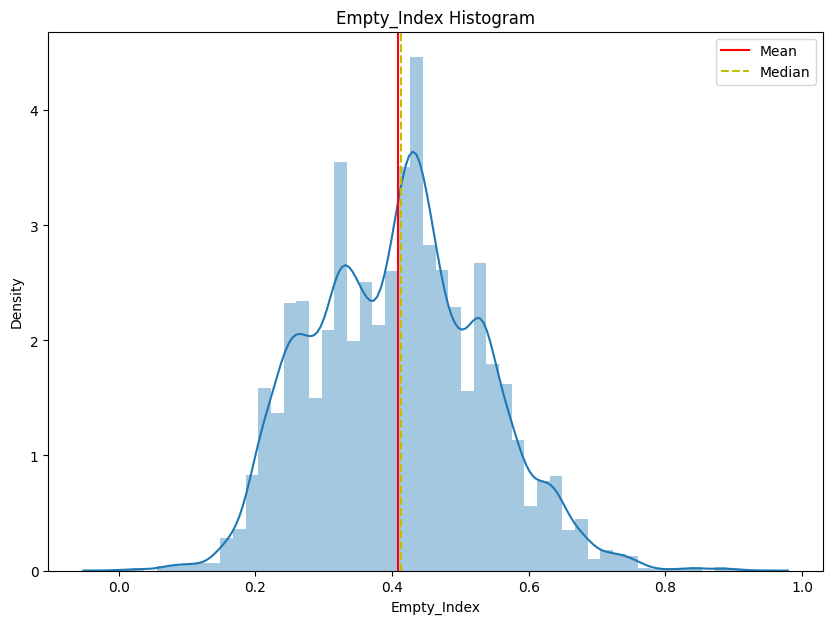

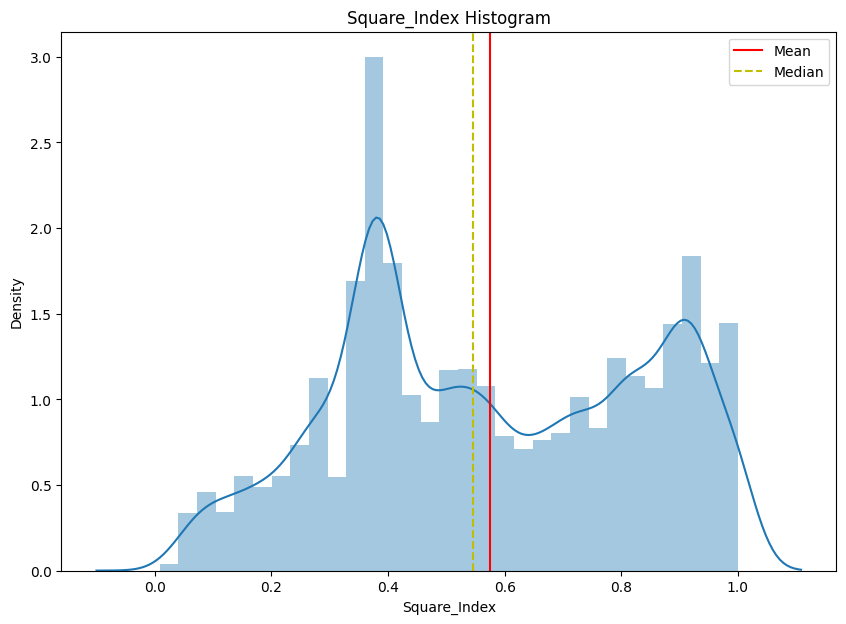

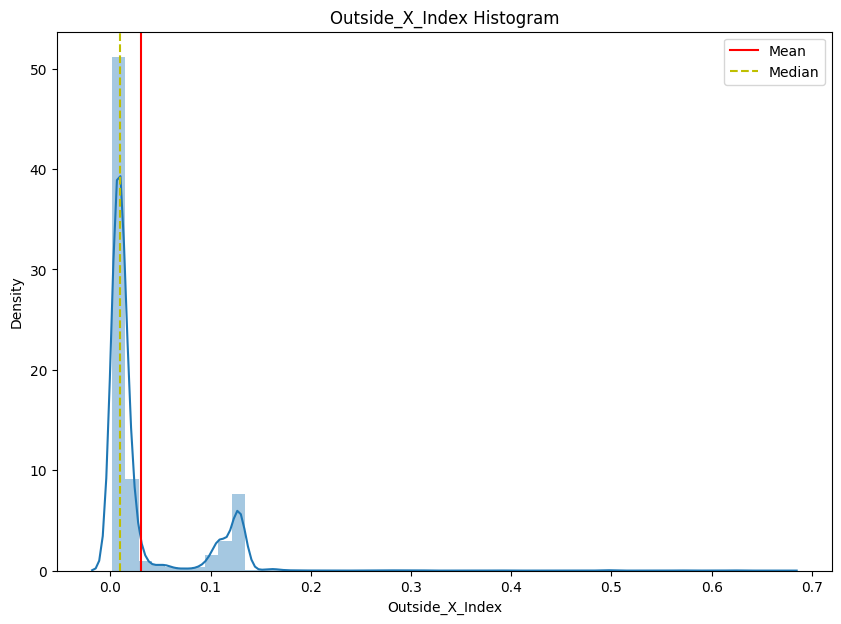

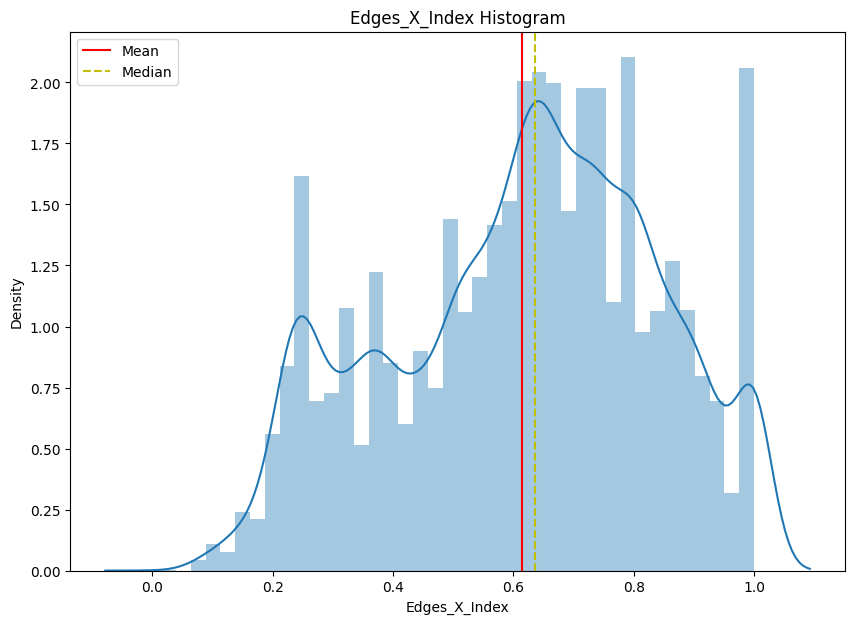

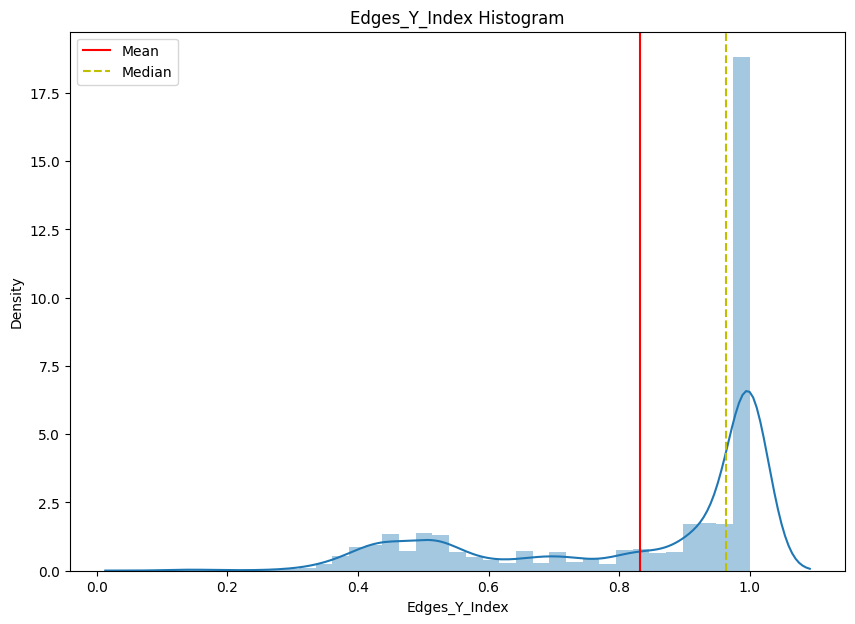

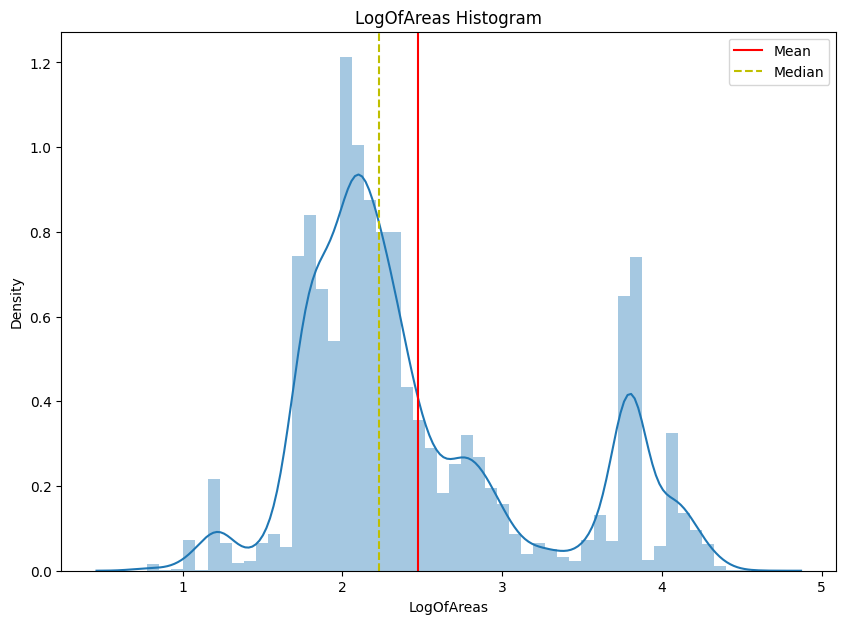

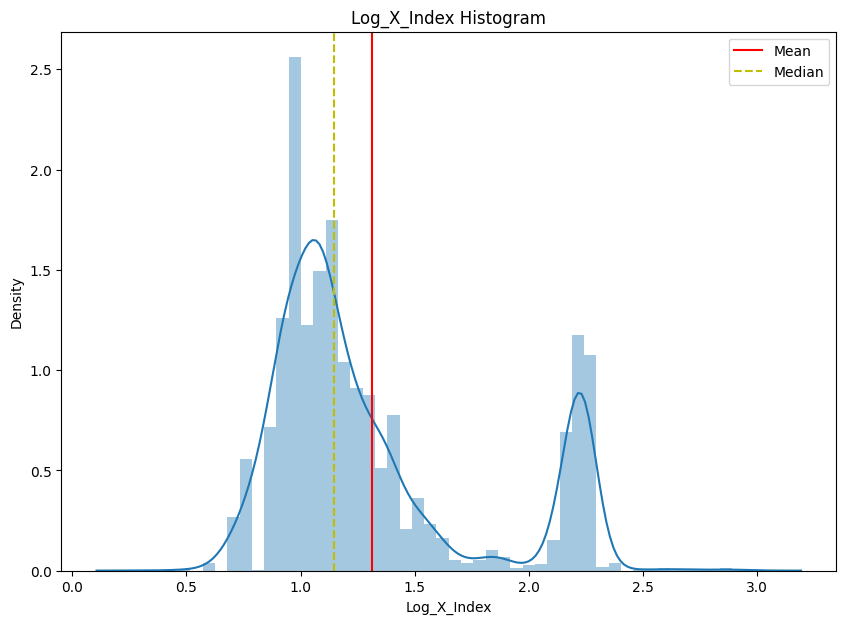

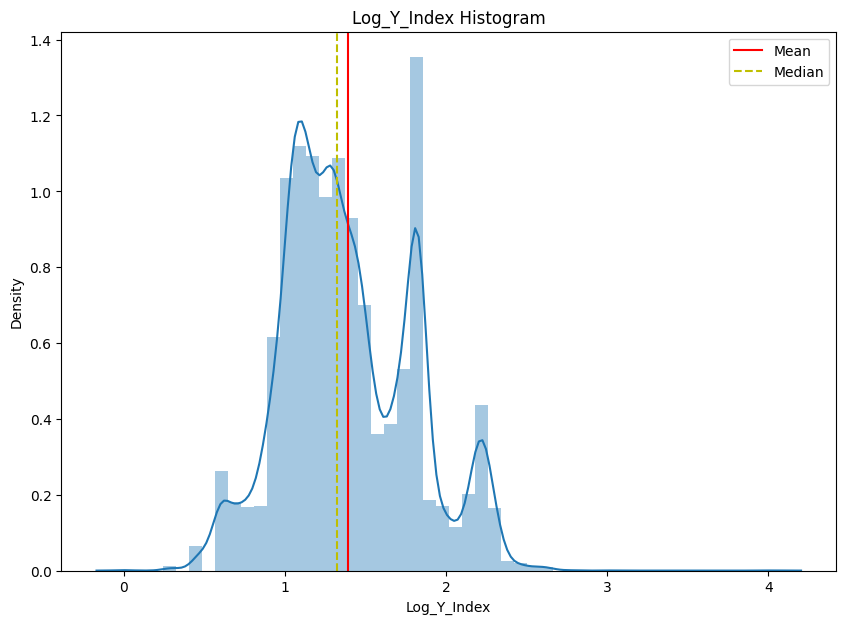

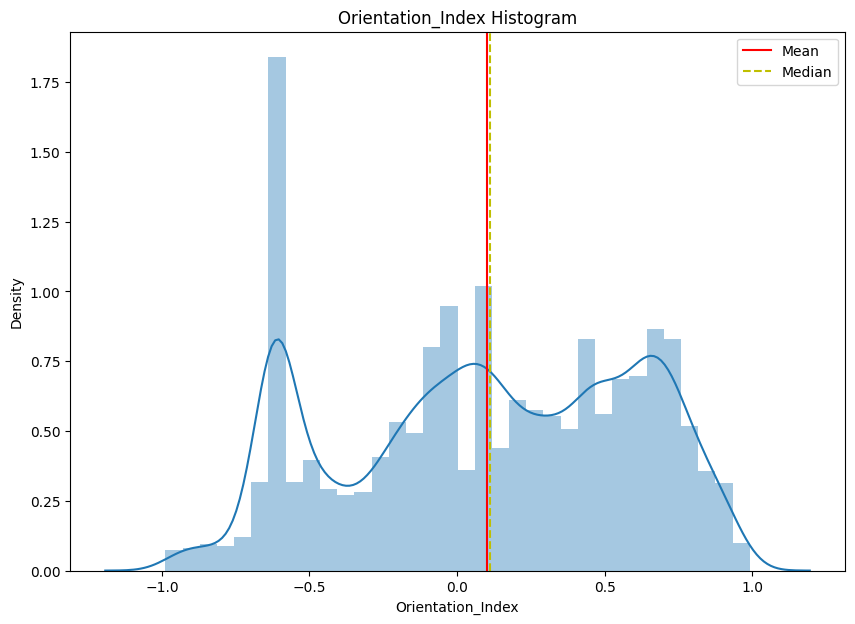

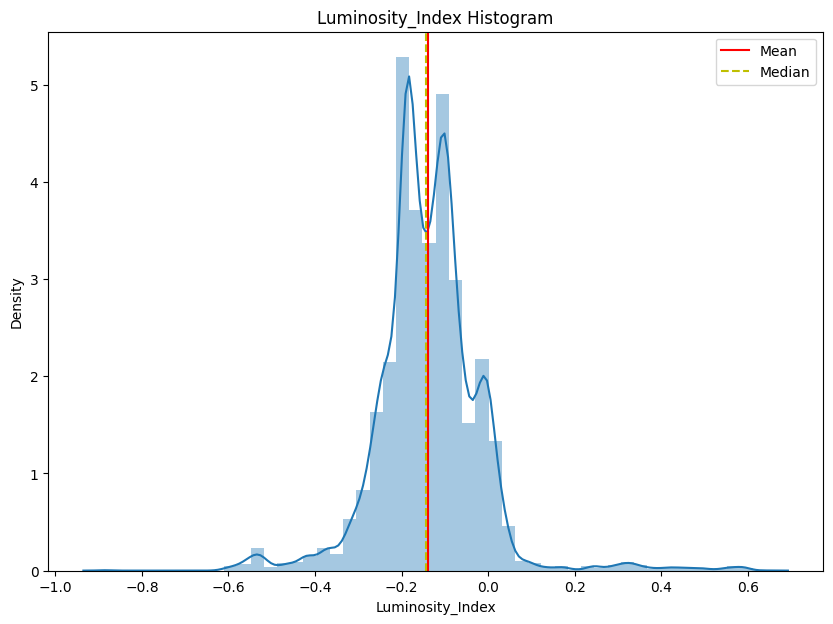

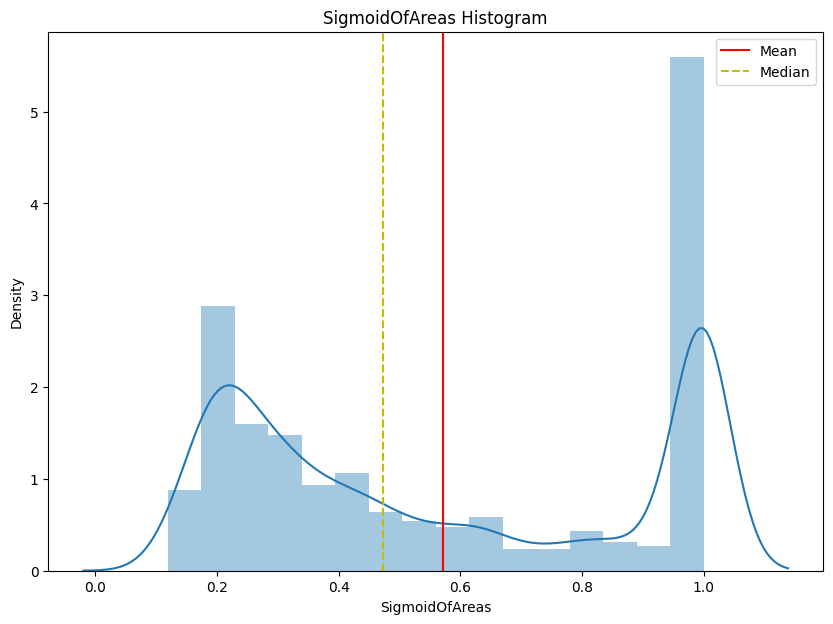

In [14]:
for col in num_cols:
    plt.figure(figsize=[10,7])
    sns.distplot(train_df[col],kde=True).set(title= col+' Histogram')
    plt.axvline(train_df[col].mean(),color='r', label='Mean')
    plt.axvline(train_df[col].median(),color='y', linestyle='--',label='Median')
    plt.legend()
    plt.show()

# Correlation Plot to assess the correlation between the features

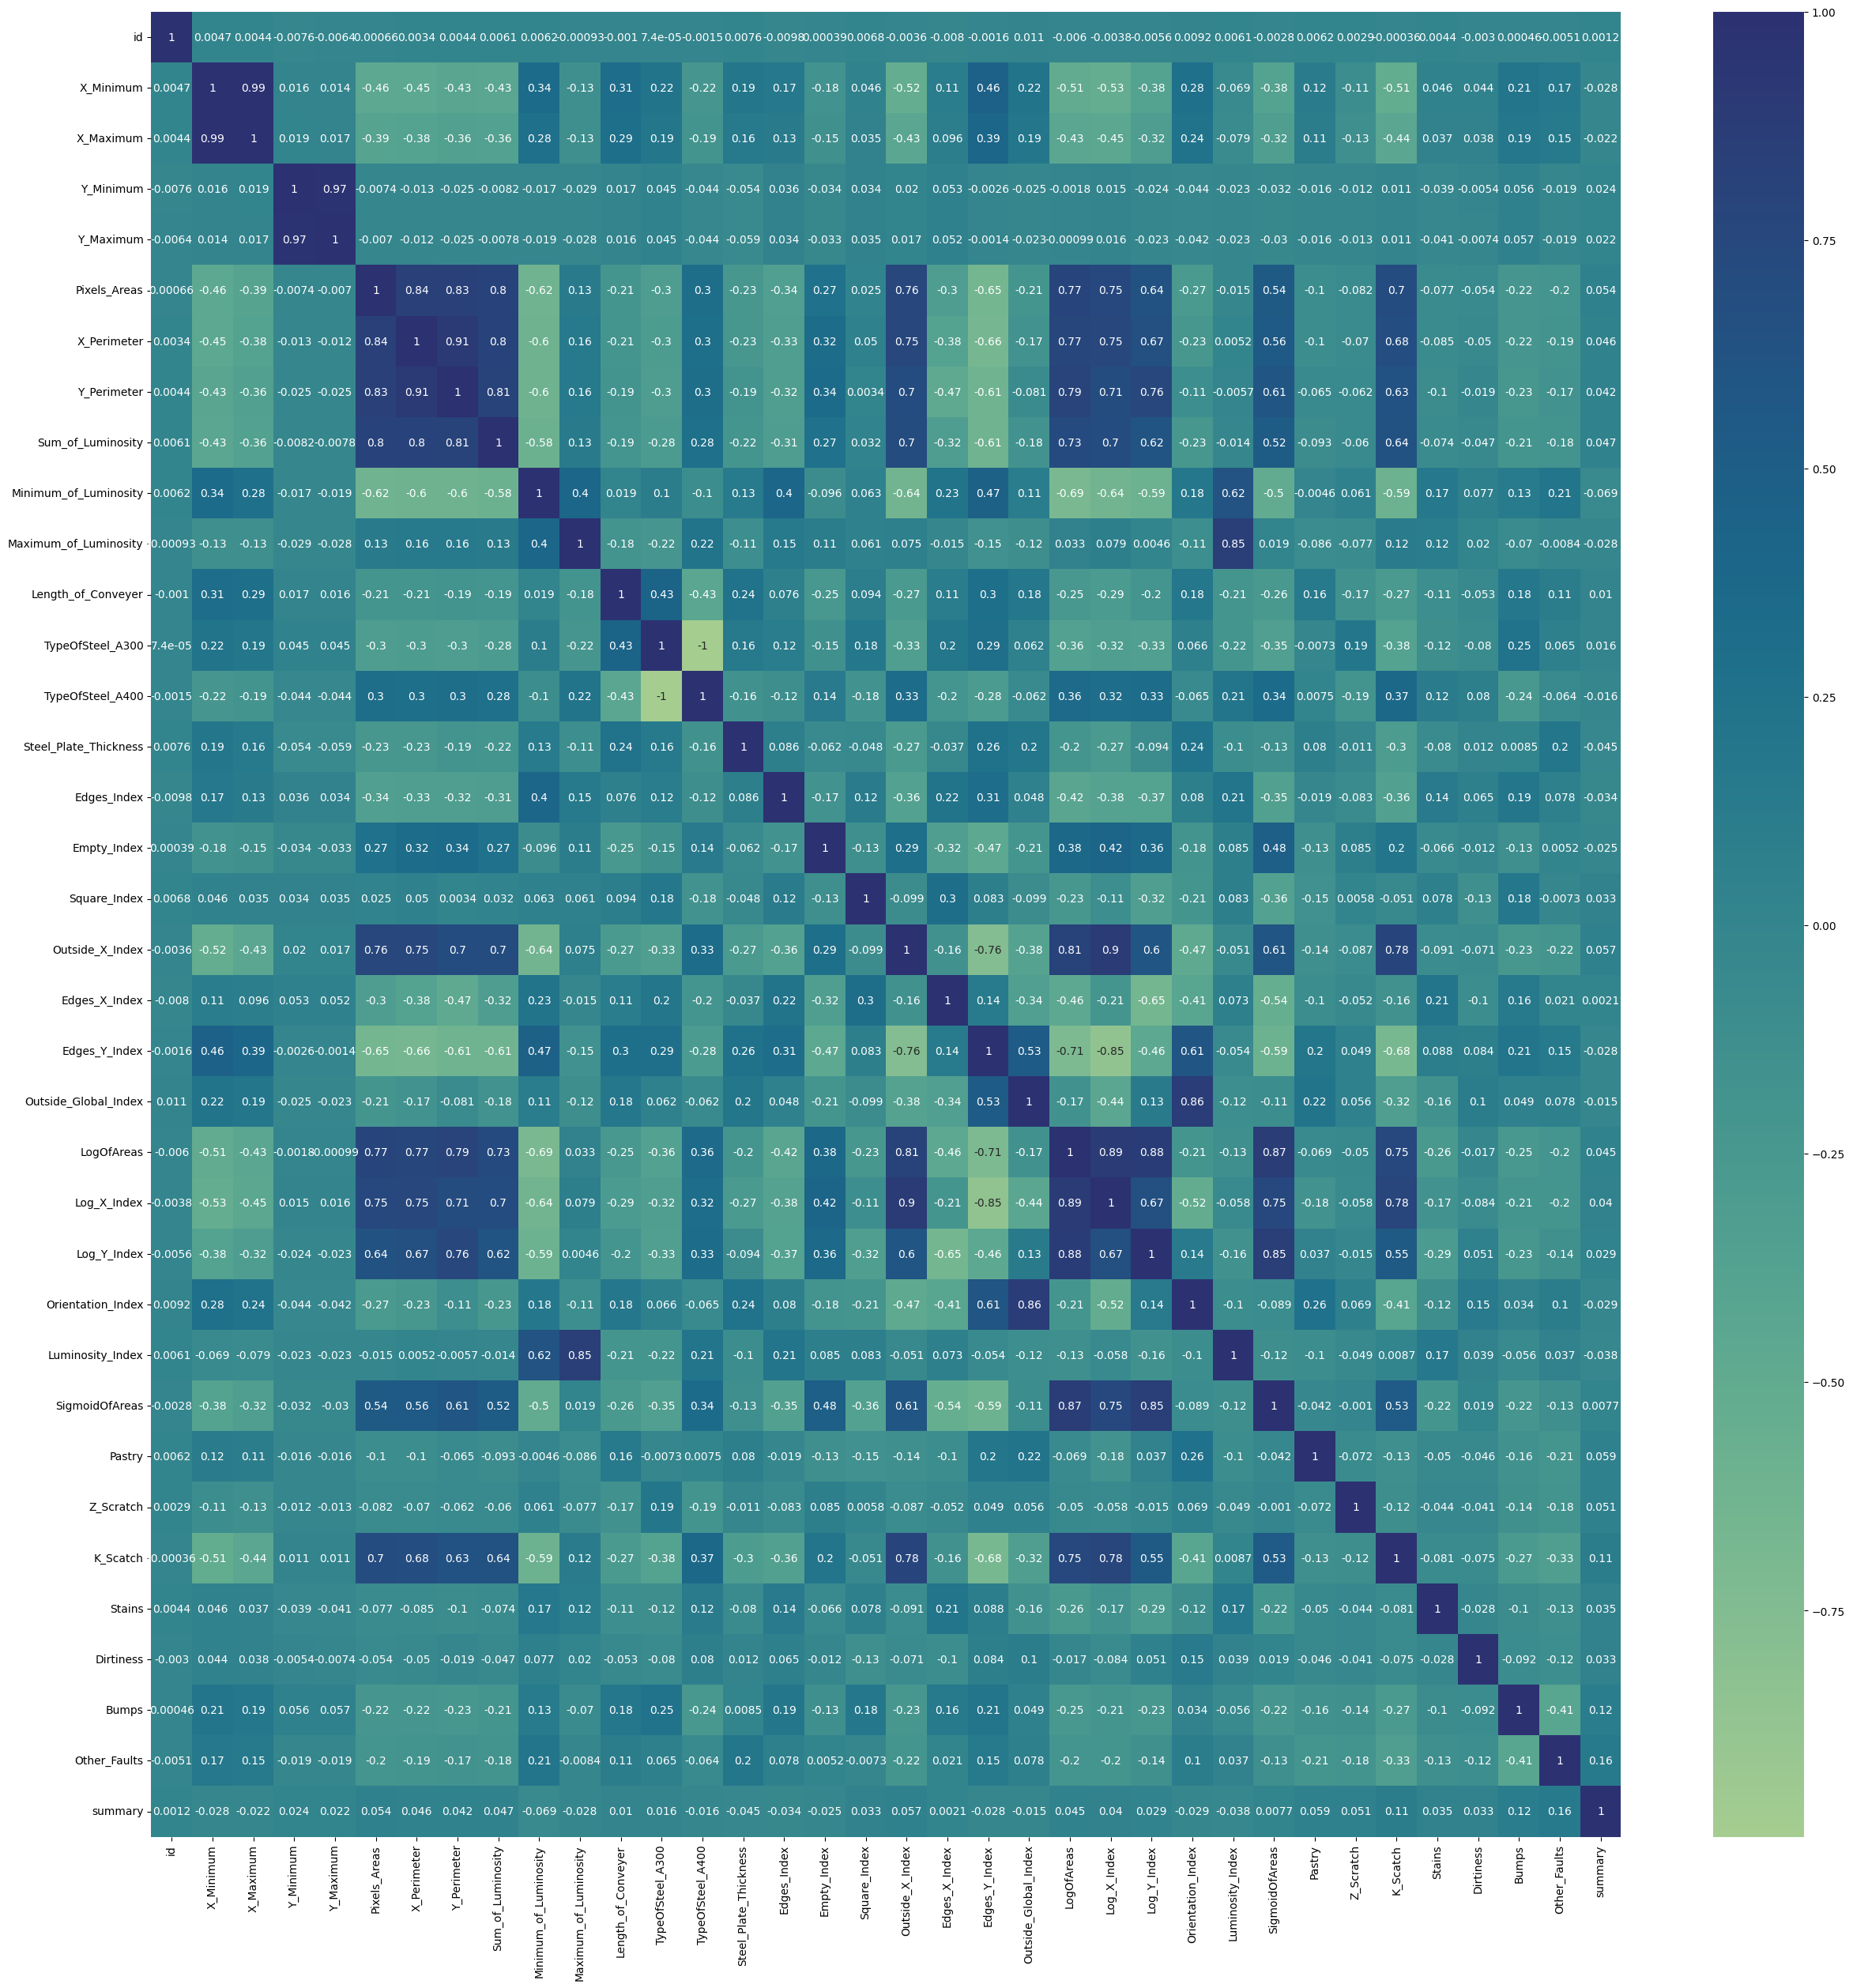

In [15]:
corr = train_df.corr()
# plot the heatmap
plt.figure(figsize=(30,30))
s=sns.heatmap(corr,annot=True, cmap='crest')

# Preparing Testing and Training Datasets.

## Removing the 22 rows with multiple defects


In [16]:
train_df=train_df[train_df['summary']<=1]

In [17]:
def scale(X):
    from sklearn import preprocessing
    scaled=preprocessing.StandardScaler()
    scaler=scaled.fit(X)
    X=scaler.transform(X)
    return X

In [18]:
X=train_df.drop(columns=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults','summary' ])
y=train_df[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults' ]]

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(scale(X),y,train_size=0.75, random_state=42)
X.keys()
test_df=scale(test)

In [20]:
def class_dict_balance(a):
    from sklearn.utils.class_weight import compute_class_weight
    class_dict={}
    for class_name in a.columns:
        class_weights=compute_class_weight(class_weight="balanced", classes=a[class_name].unique(), y=a[class_name])
        class_dict[class_name]= class_weights
    return class_dict
class_dict=dict(class_dict_balance(y))
print('Final Weight Dict: ',class_dict)

Final Weight Dict:  {'Pastry': array([0.54130717, 6.55221843]), 'Z_Scratch': array([0.53185949, 8.34695652]), 'K_Scatch': array([0.60803193, 2.81413075]), 'Stains': array([16.89964789,  0.51524423]), 'Dirtiness': array([ 0.51295891, 19.79175258]), 'Bumps': array([0.66488883, 2.01617307]), 'Other_Faults': array([0.75833465, 1.467737  ])}


# Training the Model

In [21]:
def evaluate(y_test,ypred):
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    print("Accuracy: ",accuracy_score(y_test,y_pred)) 
    print("Recall Score: ", recall_score(y_test,y_pred, average='macro')) #Recall measures the proportion of true positive predictions among all actual positive instalnces. If we predicted 100 survived correctly whereas actually 100 survived out of which 67 predicted correctly so recall will be 0.67
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    s=sns.heatmap(cm,annot=True, cmap='Reds')

In [22]:
def plot_history(history):
    hist1=pd.DataFrame(history.history)
    hist1['epoch']=history.epoch
    
   # 'CategoricalCrossentropy', 'accuracy', 'loss', 'mae',
    #   'val_CategoricalCrossentropy', 'val_accuracy', 'val_loss', 'val_mae',
     #  'epoch'
#hist1=hist.tail(550)
#sns.lineplot(data=histsamp, y='val_mse', x='epoch')
    print(hist1.columns)
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.plot(hist1['epoch'],hist1['mae'], label='Train Error')
    plt.plot(hist1['epoch'], hist1['val_mae'], label='Val_Error')
    plt.legend()
#plt.ylim([0, 0.2])
    if 'CategoricalCrossentropy' in hist1.columns:
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Categorical Crossentropy')
        plt.plot(hist1['epoch'],hist1['CategoricalCrossentropy'], label='Train CCE')
        plt.plot(hist1['epoch'], hist1['val_CategoricalCrossentropy'], label='Val_CCE')
        plt.legend()
    
    if 'accuracy' in hist1.columns:
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.plot(hist1['epoch'],hist1['accuracy'], label='Accuracy')
        plt.plot(hist1['epoch'], hist1['val_accuracy'], label='Val Accuracy')
        plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist1['epoch'],hist1['loss'], label='Loss')
    plt.plot(hist1['epoch'], hist1['val_loss'], label='Val Loss')
    plt.legend()

# Parameters Tuning by Optuna

    
 [The Trial Study deployed is similar to as in the notebook with few changes relevant to this dataset](https://www.kaggle.com/code/najeebz/titanic-deep-learning-tensorflow-optuna-optimized)

In [23]:
# Optuna example that optimizes multi-layer perceptrons using Tensorflow (Eager Execution).

import optuna
from packaging import version

import tensorflow as tf

BATCHSIZE = 32
CLASSES = 7
EPOCHS = 10
LOSS=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
EndActivation= 'softmax'


def create_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    weight_decay = trial.suggest_float("weight_decay", 1e-9, 1e-5, log=True)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=[len(X.keys())]))
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 1024, log=True)
        model.add(
            tf.keras.layers.Dense(
                num_hidden,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            )
        )
    model.add(
        tf.keras.layers.Dense(CLASSES, activation=EndActivation, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
    )
    return model


def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = [
                   #      "RMSprop", 
                   #      "Adam", 
                   #      "SGD", 
                   #      'Nadam',
                   ##      'Lion',
                   #      'Ftrl',
                   #      'Adamax',
                         'AdamW',
                   #      'Adagrad',
                   #      'Adafactor',
                   #      'Adadelta'
                        ]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "RMSprop_learning_rate", 1e-7, 1e-4, log=True
        )
        kwargs["weight_decay"] = trial.suggest_float("RMSprop_weight_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("RMSprop_momentum", 1e-3, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("Adam_learning_rate", 1e-7, 1e-4, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "SGD_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("SGD_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Nadam":
        kwargs["learning_rate"] = trial.suggest_float("Nadam_learning_rate", 1e-7, 1e-4, log=True)
    elif optimizer_selected == "Lion":
        kwargs["learning_rate"] = trial.suggest_float("Lion_learning_rate", 1e-7, 1e-4, log=True)
    elif optimizer_selected == "Ftrl":
        kwargs["learning_rate"] = trial.suggest_float("Ftrl_learning_rate", 1e-7, 1e-4, log=True)
    elif optimizer_selected == "Adamax":
        kwargs["learning_rate"] = trial.suggest_float("Adamax_learning_rate", 1e-7, 1e-4, log=True)
    elif optimizer_selected == "AdamW":
        kwargs["learning_rate"] = trial.suggest_float("AdamW_learning_rate", 1e-9, 1e-5, log=True)
    elif optimizer_selected == "Adagrad":
        kwargs["learning_rate"] = trial.suggest_float("Adagrad_learning_rate", 1e-7, 1e-4, log=True)
    elif optimizer_selected == "Adafactor":
        kwargs["learning_rate"] = trial.suggest_float("Adafactor_learning_rate", 1e-7, 1e-4, log=True)
    elif optimizer_selected == "Adadelta":
        kwargs["learning_rate"] = trial.suggest_float("Adadelta_learning_rate", 1e-7, 1e-4, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer


def objective(trial):

    # Build model and optimizer.
    model = create_model(trial)
    optimizer = create_optimizer(trial)
    model.compile(
        loss=LOSS,
        optimizer=optimizer,
        metrics=["accuracy"],
    )

    model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        shuffle=True,
     #   batch_size=BATCHSIZE,
        epochs=EPOCHS,
        class_weight=class_dict,
        verbose=False,
    )
#x_train,x_test,y_tftrain,y_tftest
    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1000)

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print('EPOCHS: ',EPOCHS)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-03-17 21:23:18,191] A new study created in memory with name: no-name-feeacd66-3e15-4e61-89da-a2a9a7db4be3
[I 2024-03-17 21:23:29,158] Trial 0 finished with value: 0.31937500834465027 and parameters: {'n_layers': 2, 'weight_decay': 6.09052355206388e-06, 'n_units_l0': 73, 'n_units_l1': 808, 'optimizer': 'AdamW', 'AdamW_learning_rate': 3.180109203250357e-07}. Best is trial 0 with value: 0.31937500834465027.
[I 2024-03-17 21:23:36,434] Trial 1 finished with value: 0.20291666686534882 and parameters: {'n_layers': 1, 'weight_decay': 3.103605344861353e-06, 'n_units_l0': 23, 'optimizer': 'AdamW', 'AdamW_learning_rate': 7.187929805255379e-07}. Best is trial 0 with value: 0.31937500834465027.
[I 2024-03-17 21:23:44,027] Trial 2 finished with value: 0.4206250011920929 and parameters: {'n_layers': 1, 'weight_decay': 8.17858360365621e-08, 'n_units_l0': 138, 'optimizer': 'AdamW', 'AdamW_learning_rate': 2.2729332755065706e-06}. Best is trial 2 with value: 0.4206250011920929.
[I 2024-03-17 21:

Number of finished trials:  1000
Best trial:
  Value:  0.559374988079071
EPOCHS:  10
  Params: 
    n_layers: 3
    weight_decay: 5.8169079359659955e-09
    n_units_l0: 1021
    n_units_l1: 816
    n_units_l2: 278
    optimizer: AdamW
    AdamW_learning_rate: 8.559018274488931e-06


In [24]:
def get_optimizer(params):
    optimizer_name = params["optimizer"]
    learning_rate=params[optimizer_name+'_learning_rate']
    if optimizer_name == "Adam":
        return tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "RMSprop":
        wd=params[optimizer_name+'_weight_decay']
        momentum=params[optimizer_name+'_momentum']
        return tf.keras.optimizers.RMSprop(learning_rate=learning_rate, weight_decay=wd,momentum=momentum)
    elif optimizer_name == "SGD":
        momentum=params[optimizer_name+'_momentum']
        return tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    elif optimizer_name == "Nadam":
        return tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer_name == "Lion":
        return tf.keras.optimizers.Lion(learning_rate=learning_rate)
    elif optimizer_name == "Ftrl":
        return tf.keras.optimizers.Ftrl(learning_rate=learning_rate)
    elif optimizer_name == "Adamax":
        return tf.keras.optimizers.Adamax(learning_rate=learning_rate)
    elif optimizer_name == "AdamW":
        return tf.keras.optimizers.AdamW(learning_rate=learning_rate)
    elif optimizer_name == "Adagrad":
        return tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_name == "Adafactor":
        return tf.keras.optimizers.Adafactor(learning_rate=learning_rate)
    elif optimizer_name == "Adadelta":
        return tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

# Creating the Model

In [25]:
best_trial = study.best_trial
best_params = best_trial.params
mod = create_model(study.best_trial)
mod.compile(optimizer=get_optimizer(best_trial.params), loss=LOSS, 
                                   metrics=['mae','accuracy',LOSS])
mod.summary()

Model: "sequential_1000"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1000        │ (None, 28)             │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3920 (Dense)              │ (None, 1021)           │        29,609 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3921 (Dense)              │ (None, 816)            │       833,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3922 (Dense)              │ (None, 278)            │       227,126 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3923 (Dense)              │ (None, 7)              │         1,953 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,092,752 (4.17 MB)

 Trainable params: 1,092,696 (4.17 MB)

 Non-trainable params: 56 (224.00 B)

In [26]:
print(class_dict)

{'Pastry': array([0.54130717, 6.55221843]), 'Z_Scratch': array([0.53185949, 8.34695652]), 'K_Scatch': array([0.60803193, 2.81413075]), 'Stains': array([16.89964789,  0.51524423]), 'Dirtiness': array([ 0.51295891, 19.79175258]), 'Bumps': array([0.66488883, 2.01617307]), 'Other_Faults': array([0.75833465, 1.467737  ])}


# Training the Model

In [27]:
epoch=EPOCHS*10
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            min_delta=0.0001,
                                            patience=(20),
                                            start_from_epoch=(epoch/10),
                                            restore_best_weights=True,
                                            mode='auto'
                                            )
history=mod.fit(X_train,y_train, 
                epochs=epoch, 
                verbose=1, 
                validation_data=(X_test, y_test),
                callbacks=[early_stop], 
                class_weight=class_dict
               )
print('Results: ',mod.evaluate(X_test,y_test))

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3776 - categorical_crossentropy: 1.5711 - loss: 1.5711 - mae: 0.2185 - val_accuracy: 0.5096 - val_categorical_crossentropy: 1.1476 - val_loss: 1.1476 - val_mae: 0.1757
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5104 - categorical_crossentropy: 1.1358 - loss: 1.1358 - mae: 0.1743 - val_accuracy: 0.5215 - val_categorical_crossentropy: 1.0512 - val_loss: 1.0512 - val_mae: 0.1665
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5274 - categorical_crossentropy: 1.0571 - loss: 1.0571 - mae: 0.1663 - val_accuracy: 0.5448 - val_categorical_crossentropy: 0.9996 - val_loss: 0.9996 - val_mae: 0.1610
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5490 - categorical_crossentropy: 1.0150 - loss: 1.0150 - mae: 0.1625 - val_accuracy: 0.5492 - val_categorical_crossentropy: 0.9744 - val_loss: 0.9745 - val_mae: 0.1583
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accur

# Evaluating the Training Process

Index(['accuracy', 'categorical_crossentropy', 'loss', 'mae', 'val_accuracy',
       'val_categorical_crossentropy', 'val_loss', 'val_mae', 'epoch'],
      dtype='object')


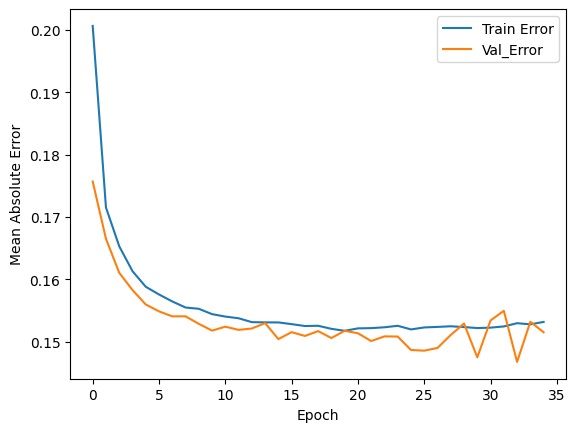

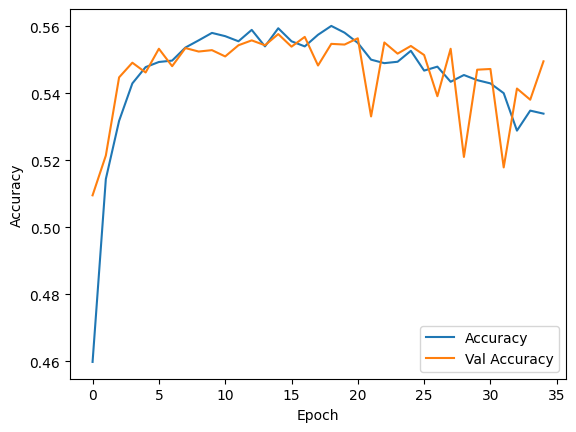

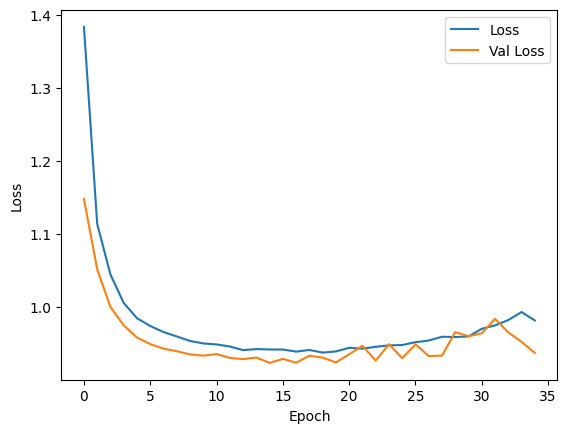

In [28]:
plot_history(history)

# Predicting the Results

In [29]:
result=np.round(mod.predict(test_df),1)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [30]:
result

array([[0.4, 0. , 0. , ..., 0.1, 0.1, 0.4],
       [0.2, 0. , 0. , ..., 0.2, 0.1, 0.5],
       [0. , 0.1, 0.1, ..., 0. , 0.3, 0.5],
       ...,
       [0. , 0. , 0.9, ..., 0. , 0. , 0.1],
       [0.3, 0. , 0. , ..., 0.1, 0.2, 0.3],
       [0. , 0. , 1. , ..., 0. , 0. , 0. ]], dtype=float32)

# Making the Submission File

In [31]:
submission = pd.DataFrame( result, columns=y.keys())

In [32]:
submission.insert(0, 'id', test['id']) 

In [33]:
submission

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.4,0.0,0.0,0.0,0.1,0.1,0.4
1,19220,0.2,0.0,0.0,0.0,0.2,0.1,0.5
2,19221,0.0,0.1,0.1,0.0,0.0,0.3,0.5
3,19222,0.1,0.0,0.0,0.0,0.0,0.4,0.5
4,19223,0.0,0.0,0.0,0.0,0.0,0.5,0.4
...,...,...,...,...,...,...,...,...
12809,32028,0.2,0.1,0.0,0.0,0.1,0.2,0.4
12810,32029,0.2,0.0,0.0,0.0,0.1,0.2,0.4
12811,32030,0.0,0.0,0.9,0.0,0.0,0.0,0.1
12812,32031,0.3,0.0,0.0,0.0,0.1,0.2,0.3


In [34]:
submission.to_csv('submission.csv', index=False)

In [35]:
submission.head(30)

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.4,0.0,0.0,0.0,0.1,0.1,0.4
1,19220,0.2,0.0,0.0,0.0,0.2,0.1,0.5
2,19221,0.0,0.1,0.1,0.0,0.0,0.3,0.5
3,19222,0.1,0.0,0.0,0.0,0.0,0.4,0.5
4,19223,0.0,0.0,0.0,0.0,0.0,0.5,0.4
5,19224,0.1,0.4,0.0,0.0,0.0,0.3,0.3
6,19225,0.3,0.0,0.0,0.0,0.0,0.1,0.6
7,19226,0.1,0.1,0.0,0.0,0.1,0.2,0.6
8,19227,0.0,0.2,0.1,0.0,0.0,0.2,0.5
9,19228,0.2,0.0,0.0,0.0,0.0,0.3,0.5
